In [ ]:
!pip install qibo
!pip install qibojit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 16

# Qibo: advanced applications

In this notebook we present some advanced applications using Qibo

## Backends

Qibo provides backends for quantum simulation on classical hardware and quantum hardware management and control. In the image below we present a schematic view of the currently supported backends.

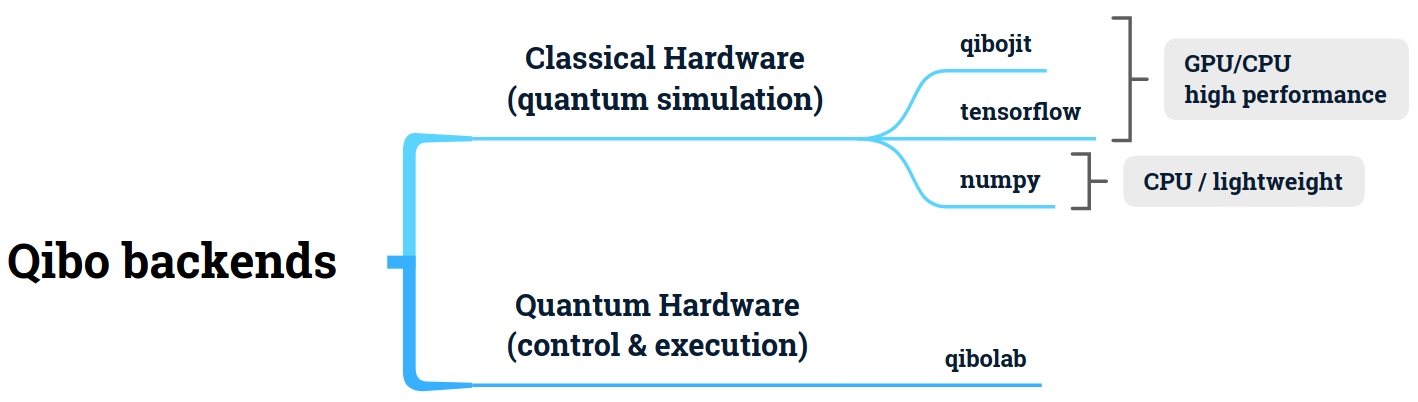

## Simulation backends
We provide multiple simulation backends for Qibo, which are automatically loaded if the corresponding packages are installed, following the hierarchy below:

* [qibojit](https://github.com/qiboteam/qibojit): an efficient simulation backend for CPU, GPU and multi-GPU based on just-in-time (JIT) compiled custom operators. Install this package if you need to simulate quantum circuits with large number of qubits or complex quantum algorithms which may benefit from computing parallelism.

* tensorflow: a pure TensorFlow implementation for quantum simulation which provides access to gradient descent optimization and the possibility to implement classical and quantum architectures together. This backend is not optimized for memory and speed, use qibojit instead.

* numpy: a lightweight quantum simulator shipped with the qibo base package. Use this simulator if your CPU architecture is not supported by the other backends. Please note that the simulation performance is quite poor in comparison to other backends.

### How to change backend?
In Qibo it is possible to change the backend using the `set_backend` method:

In [ ]:
from qibo.backends import set_backend

set_backend("qibojit")
set_backend("tensorflow")
set_backend("numpy")

## Callbacks

Often you may want to apply one or more functions to the state vector while you are executing a quantum circuit. These are often referred to as **Callbacks**. 

For example you may want to compute the [entaglement entropy](https://en.wikipedia.org/wiki/Entropy_of_entanglement) as the state propages through the circuit, which has the following expression

$$ S = \text{Tr} (\rho \log_2 \rho)$$



Lets see how the entropy changes through the circuit that prepares the [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state), 
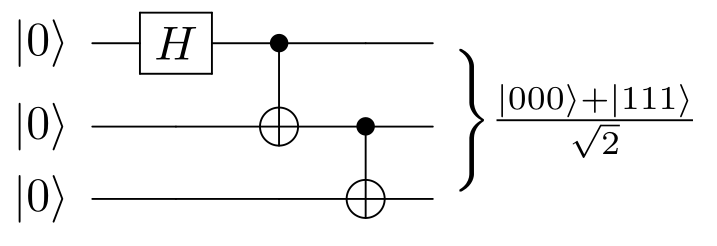

In [ ]:
from qibo import callbacks, models, gates

nqubits = 3

# decide how to partition the system for the entropy calculation
partition = list(range(nqubits // 2))
#partition = [0]
entropy = callbacks.EntanglementEntropy(partition)

circuit = models.Circuit(nqubits)
circuit.add(gates.CallbackGate(entropy))
circuit.add(gates.H(0))
for i in range(nqubits - 1):
    circuit.add(gates.CallbackGate(entropy))
    circuit.add(gates.CNOT(i, i + 1))

final_state = circuit()
print(final_state)
print(circuit.draw(legend=True))

In [ ]:
plt.plot(entropy[:], linewidth=2.0, marker="o", markersize=6)
plt.xlabel("Gates applied")
plt.ylabel("Von Neumann Entropy")
plt.show()

As we can see the entropy increases after the first CNOT gate since we have entangled the qubits.

## Parametrized gates

In Quantum Computing there are several gates which have one or more free parameters. For example a rotation around the x axis on the Bloch sphere is described by the following gate
$$
 R_x ( θ ) = \begin{pmatrix}
        \cos \frac{\theta }{2}  &
        -i\sin \frac{\theta }{2} \\
        -i\sin \frac{\theta }{2}  &
        \cos \frac{\theta }{2} \\
        \end{pmatrix} 
$$
Parametrized gates are particularly used especially in Quantum Machine Learning in order to build Variational Quantum Circuits (VQC).

In Qibo, after having allocated the circuit, it is possibile to set at once the value of the parameters required by the circuit using the `set_parameters` method.

In [ ]:
from qibo.models import Circuit
from qibo import gates
# create a circuit with all parameters set to 0.
c = Circuit(3)
c.add(gates.RX(0, theta=0))
c.add(gates.RY(1, theta=0))
c.add(gates.CZ(1, 2))
c.add(gates.fSim(0, 2, theta=0, phi=0))
c.add(gates.H(2))

# set new values to the circuit's parameters
params = [0.123, 0.456, (0.789, 0.321)]
c.set_parameters(params)

## Circuit operations

Once you have a `Circuit` object you can perform different operations with it.

Lets start from a very simple circuit:

In [ ]:
from qibo import models, gates

circuit = models.Circuit(2)
circuit.add([gates.H(i) for i in range(2)])
circuit.add(gates.X(0))
circuit.add(gates.Y(1))

print(circuit.draw())

We can compute the inverse of quantum circuit using the `invert` method

In [ ]:
inverse = circuit.invert()
print(inverse.draw())

We also have the possibility to add two circuit together. Lets add the first circuit with its inverse.

In [ ]:
identity = circuit + inverse
print(identity.draw())

Since $X X = Y Y = H H = I$ we can cleary see that we have correctly computed the inverse.

We can also check this using the method `unitary` which will give a matrix representation of the all circuit.

In [ ]:
print(identity.unitary())

Finally we can obtain some general information about a quantum circuit using `summary`

In [ ]:
print(identity.summary())

## Adding noise to your simulation
 
Qibo offers also the possibility to perform noisy simulations in various ways including:
* Density matrices
* Repeated execution
* Noise Model
* Measurement errors

### Using density Matrices
In Qibo a quantum circuit can be used to evolve density matrices instead of the state vectors.

All you need to is to pass the option `density_matrix=True` when allocating a circuit.

In [ ]:
density = models.Circuit(nqubits=2, density_matrix=True)
density.add(gates.H(0))
density.add(gates.H(1))
density.add(gates.M(0,1))

final_density = density()
print(final_density)

Therefore we are performing the following transformation
$$ |00 \rangle \langle 00| \rightarrow (H_1 \otimes H_2)|00 \rangle \langle 00|(H_1 \otimes H_2)^\dagger = |++ \rangle \langle ++|
$$

**Why are density matrices useful to introduce noise?**

Using density matrices it is possible to implement *Quantum Operations* 
$$ \rho \longrightarrow \mathcal{E}(\rho)$$
Two of the simplest examples of quantum operations are unitary transformation and measurements. In Qibo we have specific channels that implement quantum operations to add noise to the system such as:
* Pauli Noise $$ \mathcal{E}(\rho ) = (1 - p_x - p_y - p_z) \rho + p_x X \rho X + p_y Y \rho Y + p_z Z \rho Z $$
* Reset $$\mathcal{E}(\rho ) = (1 - p_0 - p_1) \rho +  \mathrm{Tr}\rho \otimes (p_0|0\rangle \langle 0| + p_1|1\rangle \langle 1|) $$


and many more
        

For example lets add a Pauli Noise to both qubits in the previous density matrix circuit.

In [ ]:
noisy_circuit = models.Circuit(nqubits=2, density_matrix=True)
noisy_circuit.add([gates.H(0), gates.H(1)])
noisy_circuit.add(gates.PauliNoiseChannel(0, px=0.1, py=0.2))
noisy_circuit.add(gates.PauliNoiseChannel(1, px=0.1, py=0.2))
noisy_circuit.add(gates.M(0,1))

noisy_results = noisy_circuit(nshots=1000)
ideal_results = density(nshots = 1000)

In [ ]:
labels, ideal_values = zip(*ideal_results.frequencies().items())
labels, noisy_values = zip(*noisy_results.frequencies().items())

plt.figure(figsize=(7, 4))
plt.bar(labels, np.array(ideal_values)/len(ideal_results.samples()), alpha=0.5, width=0.4, label="Simulation")
plt.bar(labels, np.array(noisy_values)/len(noisy_results.samples()), alpha=0.5, width=0.4, label="Noisy")
plt.legend()
plt.show()

## Using repeated execution

The major limitation using density matrices is the the fact that they are memory intensive.

In Qibo we have the possibility to add noise to the circuit by simply repeating the execution when a noise channel is included in the circuit.

In [ ]:
import numpy as np
from qibo import models, gates

# Define circuit
c = models.Circuit(5)
thetas = np.random.random(5)
c.add((gates.RX(i, theta=t) for i, t in enumerate(thetas)))
# Add noise channels to all qubits
c.add((gates.PauliNoiseChannel(i, px=0.2, py=0.0, pz=0.3)
       for i in range(5)))
# Add measurement of all qubits
c.add(gates.M(*range(5)))

# Repeat execution 1000 times
result = c(nshots=1000)

In this example the simulation is repeated 1000 times and the action of the `qibo.gates.PauliNoiseChannel` gate differs each time, because the error X, Y and Z gates are sampled according to the given probabilities. Note that when a channel is used, the command c(nshots=1000) has a different behavior. Normally `c(nshots=1000)` would execute the circuit once and would then sample 1000 bit-strings from the final state. When channels are used, the full is executed 1000 times because the behavior of channels is probabilistic and different in each execution. Note that now the simulation time required will increase linearly with the number of repetitions (nshots).
## Noise model

In a real quantum circuit some gates can be highly faulty and introduce errors. In order to simulate this behavior Qibo provides the `qibo.noise.NoiseModel` class which can store errors that are gate-dependent using the qibo.noise.`NoiseModel.add()` method and generate the corresponding noisy circuit with `qibo.noise.NoiseModel.apply()`. The corresponding noise is applied after every instance of the gate in the circuit. It is also possible to specify on which qubits the noise will be added.

In [ ]:
from qibo import models, gates
from qibo.noise import NoiseModel, PauliError

# Build specific noise model with 2 quantum errors:
# - Pauli error on H only for qubit 1.
# - Pauli error on CNOT for all the qubits.
noise = NoiseModel()
noise.add(PauliError(px = 0.5), gates.H, 1)
noise.add(PauliError(py = 0.5), gates.CNOT)

# Generate noiseless circuit.
c = models.Circuit(2)
c.add([gates.H(0), gates.H(1), gates.CNOT(0, 1)])

# Apply noise to the circuit according to the noise model.
noisy_c = noise.apply(c)

print("Noiseless circuit: ")
print(c.draw())

print("Noisy circuit: ")
print(noisy_c.draw(legend=True))

As we can see the `NoiseModel` has added a Pauli Noise after the Hadamard gate on qubit one and a PauliNoise after the CNOT gate, which corresponds to the following circuit:

In [ ]:
noisy_c2 = models.Circuit(2)
noisy_c2.add(gates.H(0))
noisy_c2.add(gates.H(1))
noisy_c2.add(gates.PauliNoiseChannel(1, px=0.5))
noisy_c2.add(gates.CNOT(0, 1))
noisy_c2.add(gates.PauliNoiseChannel(0, py=0.5))
noisy_c2.add(gates.PauliNoiseChannel(1, py=0.5))

print(noisy_c2.draw(legend=True))

## Measurement errors

In Qibo we also have the possibility to introduce noise after the circuit has been executed, in this way we can implement what is generally called a Measurement Error or a Readout Error.

A possible measurement error is the *bit-flip*, which corresponds to measuring a final state where one or more qubits have randomly flipped. In Qibo you can add directly a bit-flip error after executing the circuit using the `apply_bitflips` method.


In [ ]:
import numpy as np
from qibo import models, gates

thetas = np.random.random(4)
c = models.Circuit(4)
c.add((gates.RX(i, theta=t) for i, t in enumerate(thetas)))
c.add([gates.M(0, 1), gates.M(2, 3)])
result = c(nshots=100)
# add bit-flip errors with probability 0.2 for all qubits
flipped = result.apply_bitflips(0.01)

Lets count how many time we observe a bitflip.

In [ ]:
count = 0
for i in range(len(result.samples())):
  if (result.samples()[i] == flipped[i]).all():
    count += 1
print(f"Out of the 100 shots {100 - count} flipped.")

# Time evolution 
In addition to the classical simulation of quantum circuits, Qibo can be used to calculate the unitary time evolution of quantum states. We note that the full state vector is used in this simulation. Time evolution can also be used to simulate adiabatic quantum computation.

### Hamiltonians in Qibo <a class="anchor" id="hamiltonians"></a>

Unitary time evolution is usually defined through a Hamiltonian $H$. Qibo provides the `hamiltonians` module which allows users to define Hamiltonians on $n$ qubits through their full $2^n\times 2^n $ matrix. This can be done as follows:

In [ ]:
from qibo import hamiltonians
nqubits = 5
matrix = np.random.random((2 ** nqubits, 2 ** nqubits))
matrix = matrix + matrix.conj().T

ham = hamiltonians.Hamiltonian(nqubits=nqubits, matrix=matrix)
print(ham)
print(ham.nqubits)

Qibo provides pre-coded Hamiltonians for a few common Physics models, such as the [Heisenberg XXZ model](https://en.wikipedia.org/wiki/Heisenberg_model_(quantum)) or [Ising model](https://en.wikipedia.org/wiki/Ising_model) on a transverse field (TFIM). We refer to our [Hamiltonian documentation](https://qibo.readthedocs.io/en/stable/api-reference/qibo.html#hamiltonians) for more details. These can be used as:


In [ ]:
ising = hamiltonians.TFIM(nqubits=3, h=1.0)
print(ising.matrix)

Qibo Hamiltonians also provide various useful methods, such as the calculation of eigenstates and energies:

In [ ]:
eigenstates = ising.eigenvectors()
energies = ising.eigenvalues()

gs = eigenstates[:, 0]
matrix = ising.matrix

print("Ground state energy:", energies[0])
print("Ground state EV:", gs.conj().dot(matrix.dot(gs)))

### Simple unitary evolution <a class="anchor" id="simpleunitary"></a>

In the following we perform the unitary evolution under the $H = -\sum _{i=0}^n (Y_i + Z_i)$ using $| ++\dots + \rangle $ as the initial state:

In [ ]:
nqubits = 5

ham = hamiltonians.Y(nqubits=5) + hamiltonians.Z(nqubits=5)
evolution = models.StateEvolution(ham, dt=1e-2)
initial_state = np.ones(2 ** nqubits) / np.sqrt(2 ** nqubits)

final_state = evolution(final_time=1.0, initial_state=initial_state)
print(final_state)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
plt.axis("off")
ax.view_init(15, 0)
# ax.set_box_aspect((1, 1, 1))

# Sphere and axes
phis = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(phis), np.sin(phis), color="black", linewidth=2.0, linestyle="--")
ax.plot(np.cos(phis), np.sin(phis), zdir="x", color="black", linewidth=2.0)
ax.plot(np.zeros(100), np.linspace(-1, 1, 100), color="black", linewidth=1.0)
ax.plot(np.zeros(100), np.linspace(-1, 1, 100), zdir="y", color="black", linewidth=1.0)

# Bloch sphere axes labels
ax.text(0, -0.08, 1.15, r"$|0 \rangle $")
ax.text(0, -0.08, -1.3, r"$|1 \rangle $")
# time label
t_label = ax.text(0, 0.7, 1.15, "$t = 0$")

# Define Bloch sphere point
scat = ax.scatter(0, 0, 1, color="red", s=50, marker="o")
# Define Bloch sphere line
rs = np.linspace(0, 1, 100)
line, = ax.plot(rs * 0, rs * 0, rs, color="red", linewidth=2.0)

# Define evolution and initial state for one qubit
dt = 1e-2
ham = hamiltonians.Y(nqubits=1) + hamiltonians.Z(nqubits=1)
evolution = models.StateEvolution(ham, dt=dt)
state = np.ones(2) / np.sqrt(2)



def init():
    return (scat, line)


def animate(i):
    global state
    state = evolution(final_time=dt, initial_state=state)
    x = 2 * (state[0].conj() * state[1]).real
    y = 2 * (state[0] * state[1].conj()).imag
    z = np.abs(state[0]) ** 2 - np.abs(state[1]) ** 2
    
    t_label.set_text("$t = {:.2f}$".format(i * dt))
    scat._offsets3d = ([x], [y], [z])
    line.set_data(rs * x, rs * y)
    line.set_3d_properties(rs * z)
    return (scat, line)


plt.close()
# plt.show()

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

HTML(anim.to_html5_video())